# Deep Learning
## HW3 - Problem 1

Name: Amin Robatian

Student Number: 400301075

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, ops
from torchvision.transforms import ToTensor, Lambda
from sklearn.preprocessing import LabelBinarizer
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import numpy as np
import pandas as pd
import random
from math import floor
import string
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(85)
random.seed(85)
np.random.seed(85)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Part (A) - Data Preparation

In [2]:
data_dir = 'dataset/Shoe vs Sandal vs Boot Dataset'

transform = transforms.Compose([
    transforms.Resize((102, 136)),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

target_transform = Lambda(lambda y: torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
 
dataset = datasets.ImageFolder(data_dir, transform=transform,target_transform=None)

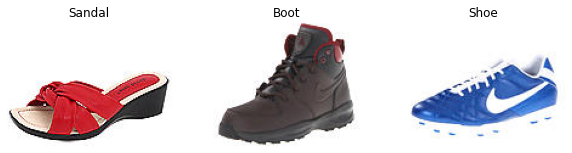

In [3]:
labels_map = {
    0: "Boot",
    1: "Sandal",
    2: "Shoe"
}
plotted_classes = []
i = 0
figure = plt.figure(figsize=(10, 10))
rows, cols = 1, 3

while len(plotted_classes) != 3:
  sample_idx = torch.randint(len(dataset), size=(1,)).item()
  img, label = dataset[sample_idx]
  if label not in plotted_classes:
    plotted_classes.append(label)
    i += 1
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))  
    
plt.show()

In [4]:
train_dataset_len = int(0.7 * len(dataset))
test_dataset_len = int(0.3 * len(dataset))

train_dataset, test_dataset = random_split(dataset, [train_dataset_len, test_dataset_len])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"The length of Train Dataset is: {len(train_dataset):,}")

print(f"The length of Test Dataset is: {len(test_dataset):,}")

The length of Train Dataset is: 10,500
The length of Test Dataset is: 4,500


# Part (B) - MLP

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*102*136, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
# creating an instance of our model
model_MLP = MLP().to(device)
print(model_MLP)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=41616, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [7]:
learning_rate = 1e-3
batch_size = 32
epochs = 10

In [8]:
def TrainDataSet_Accuracy(dataloader, model, loss_fn):
    size = floor(len(dataloader.dataset) / batch_size) * batch_size
    num_batches = floor(len(dataloader.dataset) / batch_size)
    train_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            if len(X) < batch_size:
              break
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            #
            for i in range(batch_size):
              v1 = pred[i]
              v2 = y[i]
              if torch.argmax(v1) == v2:
                correct += 1
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    print(f"Train Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    accuracy = 100*correct
    return train_loss, accuracy

In [9]:
def TestDataSet_Accuracy(dataloader, model, loss_fn):
    size = floor(len(dataloader.dataset) / batch_size) * batch_size
    num_batches = floor(len(dataloader.dataset) / batch_size)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            if len(X) < batch_size:
              break
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #
            for i in range(batch_size):
              v1 = pred[i]
              v2 = y[i]
              if torch.argmax(v1) == v2:
                correct += 1
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy = 100*correct
    return test_loss, accuracy

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_MLP.parameters(), lr=learning_rate, momentum=0.9)

train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
test_loss = np.zeros(epochs)
test_accuracy = np.zeros(epochs)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_MLP.train()
    train_loop(train_dataloader, model_MLP, loss_fn, optimizer)
    model_MLP.eval()
    train_loss[t], train_accuracy[t] = TrainDataSet_Accuracy(train_dataloader, model_MLP, loss_fn)
    test_loss[t], test_accuracy[t] = TestDataSet_Accuracy(test_dataloader, model_MLP, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 85.5%, Avg loss: 0.379827 

Test Dataset: 
 Accuracy: 85.9%, Avg loss: 0.380397 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 86.2%, Avg loss: 0.366103 

Test Dataset: 
 Accuracy: 86.4%, Avg loss: 0.359931 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 86.7%, Avg loss: 0.361385 

Test Dataset: 
 Accuracy: 86.0%, Avg loss: 0.368520 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 86.7%, Avg loss: 0.329734 

Test Dataset: 
 Accuracy: 86.5%, Avg loss: 0.339318 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 87.3%, Avg loss: 0.352528 

Test Dataset: 
 Accuracy: 87.0%, Avg loss: 0.366593 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 91.0%, Avg loss: 0.245013 

Test Dataset: 
 Accuracy: 90.2%, Avg loss: 0.262815 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 88.0%, Avg loss: 0.347081 

Test Datase

In [17]:
def TestDataSet_Accuracy1(dataloader, model, loss_fn):
    size = floor(len(dataloader.dataset) / batch_size) * batch_size
    num_batches = floor(len(dataloader.dataset) / batch_size)
    test_loss= 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            if len(X) < batch_size:
              break
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [18]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        output = model_MLP(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


In [19]:
test_loss1 = TestDataSet_Accuracy1(test_dataloader, model_MLP, loss_fn)

# constant for classes
classes = ('Boot', 'Sandal', 'Shoe')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, index = [i for i in classes],
                     columns = [i for i in classes])
accuracy = accuracy_score(y_true, y_pred)

recall = recall_score(y_true, y_pred, average='micro')

precision = precision_score(y_true, y_pred, average='micro')


**Results:**


*   Error
*   Accuracy
*   Recall
*   Precision
*   Confusion Matrix
*   Number of Network's Parameters

In [20]:
print(f'Avg Loss: {test_loss1:>8f}\n')

print(f'Accuracy: {(100*accuracy):>0.1f}%\n')

print(f'Recall: {(100*recall):>0.1f}%\n')

print(f'Precision: {(100*precision):>0.1f}%\n')

print('Confusion Matrix:\n')
print(df_cm)

print('\n')
pytorch_total_params = sum(p.numel() for p in model_MLP.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Avg Loss: 0.288045

Accuracy: 89.2%

Recall: 89.2%

Precision: 89.2%

Confusion Matrix:

             Boot     Sandal       Shoe
Boot    32.400000   0.200000   0.333333
Sandal   3.266667  30.044444   1.200000
Shoe     1.600000   4.244444  26.711111


Number of Network's Parameters: 21,834,755


# Part (C) - Diagrams

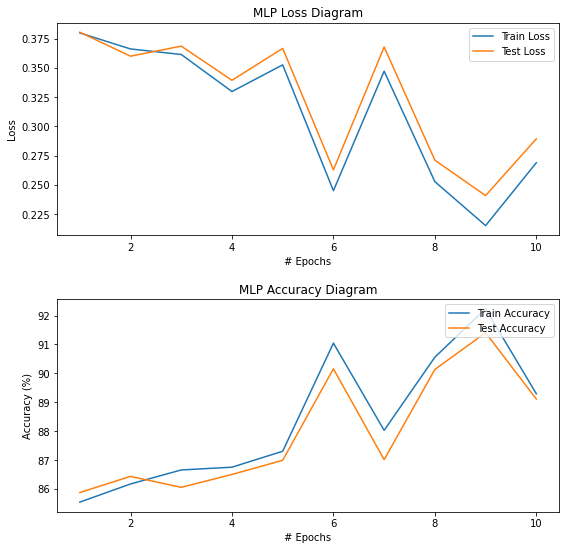

In [21]:
x = np.arange(1,epochs + 1)

figure = plt.figure(figsize=(9, 9))
rows, cols = 2, 1

figure.add_subplot(rows, cols, 1)
plt.plot(x, train_loss)
plt.plot(x, test_loss)
plt.legend(["Train Loss", "Test Loss"], loc ="upper right")
plt.title("MLP Loss Diagram")
plt.xlabel("# Epochs")
plt.ylabel("Loss")

figure.add_subplot(rows, cols, 2)
plt.plot(x, train_accuracy)
plt.plot(x, test_accuracy)
plt.legend(["Train Accuracy", "Test Accuracy"], loc ="upper right")
plt.title("MLP Accuracy Diagram")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy (%)")

plt.subplots_adjust(hspace=0.3)   
plt.show()

# Tensorboard

In [24]:
tb = SummaryWriter()

for i in x:
    tb.add_scalar('Train Loss', train_loss[i-1], i)
    tb.add_scalar('Test Loss', test_loss[i-1],i)
    tb.add_scalar('Train Accuracy', train_accuracy[i-1], i)
    tb.add_scalar('Test Accuracy', test_accuracy[i-1], i)
    
tb.close()

In [25]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


# Part (D) - CNN

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3)
        self.batch1 = nn.BatchNorm2d(16) 
        self.rel1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3)
        self.batch2 = nn.BatchNorm2d(32)
        self.rel2 = nn.ReLU()
        
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size = 2)
        self.batch3 = nn.BatchNorm2d(64)
        self.rel3 = nn.ReLU()
        
        self.drop3 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(64*97*131,3)
        
    def forward(self,inputs):
        
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.rel1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.rel2(x)
        #print(np.shape(x))
        #x = self.maxp2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.rel3(x)
        x = self.drop3(x)
        #print(np.shape(x))
        x = self.flatten(x)
        
        x = self.fc(x)
        
        return(x)

In [27]:
# creating an instance of our model
model_CNN = CNN().to(device)
print(model_CNN)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel2): ReLU()
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel3): ReLU()
  (drop3): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=813248, out_features=3, bias=True)
)


In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=learning_rate, momentum=0.9)

train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
test_loss = np.zeros(epochs)
test_accuracy = np.zeros(epochs)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_CNN.train()
    train_loop(train_dataloader, model_CNN, loss_fn, optimizer)
    model_CNN.eval()
    train_loss[t], train_accuracy[t] = TrainDataSet_Accuracy(train_dataloader, model_CNN, loss_fn)
    test_loss[t], test_accuracy[t] = TestDataSet_Accuracy(test_dataloader, model_CNN, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 92.3%, Avg loss: 0.385338 

Test Dataset: 
 Accuracy: 91.0%, Avg loss: 0.515877 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 95.5%, Avg loss: 0.125981 

Test Dataset: 
 Accuracy: 93.2%, Avg loss: 0.217172 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 97.6%, Avg loss: 0.068811 

Test Dataset: 
 Accuracy: 93.8%, Avg loss: 0.184384 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 98.1%, Avg loss: 0.051332 

Test Dataset: 
 Accuracy: 94.2%, Avg loss: 0.180817 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 98.6%, Avg loss: 0.043438 

Test Dataset: 
 Accuracy: 94.4%, Avg loss: 0.187038 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 99.6%, Avg loss: 0.019543 

Test Dataset: 
 Accuracy: 94.7%, Avg loss: 0.171674 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 99.7%, Avg loss: 0.014354 

Test Datase

In [29]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        output = model_CNN(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
        
        
test_loss1 = TestDataSet_Accuracy1(test_dataloader, model_CNN, loss_fn)

# constant for classes
classes = ('Boot', 'Sandal', 'Shoe')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, index = [i for i in classes],
                     columns = [i for i in classes])
accuracy = accuracy_score(y_true, y_pred)

recall = recall_score(y_true, y_pred, average='micro')

precision = precision_score(y_true, y_pred, average='micro')


**Results:**


*   Error
*   Accuracy
*   Recall
*   Precision
*   Confusion Matrix
*   Number of Network's Parameters

In [30]:
print(f'Avg Loss: {test_loss1:>8f}\n')

print(f'Accuracy: {(100*accuracy):>0.1f}%\n')

print(f'Recall: {(100*recall):>0.1f}%\n')

print(f'Precision: {(100*precision):>0.1f}%\n')

print('Confusion Matrix:\n')
print(df_cm)

print('\n')
pytorch_total_params = sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Avg Loss: 0.204704

Accuracy: 95.0%

Recall: 95.0%

Precision: 95.0%

Confusion Matrix:

             Boot     Sandal       Shoe
Boot    31.844444   0.711111   0.377778
Sandal   0.444444  32.800000   1.266667
Shoe     0.555556   1.622222  30.377778


Number of Network's Parameters: 2,453,315


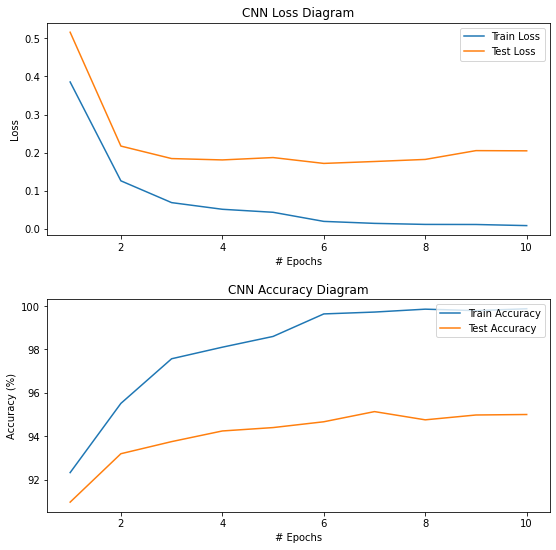

In [31]:
x = np.arange(1,epochs + 1)

figure = plt.figure(figsize=(9, 9))
rows, cols = 2, 1

figure.add_subplot(rows, cols, 1)
plt.plot(x, train_loss)
plt.plot(x, test_loss)
plt.legend(["Train Loss", "Test Loss"], loc ="upper right")
plt.title("CNN Loss Diagram")
plt.xlabel("# Epochs")
plt.ylabel("Loss")

figure.add_subplot(rows, cols, 2)
plt.plot(x, train_accuracy)
plt.plot(x, test_accuracy)
plt.legend(["Train Accuracy", "Test Accuracy"], loc ="upper right")
plt.title("CNN Accuracy Diagram")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy (%)")

plt.subplots_adjust(hspace=0.3)   
plt.show()

# Tensorboard

In [32]:
tb = SummaryWriter()

for i in x:
    tb.add_scalar('Train Loss', train_loss[i-1], i)
    tb.add_scalar('Test Loss', test_loss[i-1],i)
    tb.add_scalar('Train Accuracy', train_accuracy[i-1], i)
    tb.add_scalar('Test Accuracy', test_accuracy[i-1], i)
    
tb.close()

In [33]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


# Part (E) - MLP v.s. CNN

**Results:**

By comparing the obtained results, it can be seen that despite the fact that the CNN network has fewer parameters by an order of magnitude (MLP: 21,834,755 v.s. CNN: 2,453,315), it achieves both a lower loss (MLP: 0.288045
 v.s. CNN: 0.204704) and a higher accuracy (MLP: 89.2% v.s. CNN: 95.0%).

Also, by comparing the error graphs, it can be seen that the CNN network converges faster and its value is more stable against the local optimal points.

# Part (F) - Block Dropout

**DropBlock:** It is one of the regularization techniques [1] which outperforms the traditional regularization methods substantially especially when convolutional layers are taken into consideration.

DropBlock is a form of structured dropout where units in a contiguous
region of a feature map are dropped together. 

Extensive experiments
show that DropBlock works better than dropout in regularizing convolutional
networks.



[1] Ghiasi, Golnaz, Tsung-Yi Lin, and Quoc V. Le. “Dropblock: A regularization method for convolutional networks.” Advances in Neural Information Processing Systems. 2018.

In [63]:
from dropblock import DropBlock2D
drop_block = DropBlock2D(block_size=3, drop_prob=0.2)

In [64]:
class CNN_DropBlock(nn.Module):
    def __init__(self):
        super(CNN_DropBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3)
        self.batch1 = nn.BatchNorm2d(16) 
        self.rel1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3)
        self.batch2 = nn.BatchNorm2d(32)
        self.rel2 = nn.ReLU()
        
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size = 2)
        self.batch3 = nn.BatchNorm2d(64)
        self.rel3 = nn.ReLU()
        
        #self.drop3 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(64*97*131,3)
        
    def forward(self,inputs):
        
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.rel1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.rel2(x)
        
        #print(np.shape(x))
        #x = self.maxp2(x)
        
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.rel3(x)
        
        #x = self.drop3(x)
        
        x = drop_block(x)
        
        #print(np.shape(x))
        
        x = self.flatten(x)
        
        x = self.fc(x)
        
        return(x)

In [65]:
# creating an instance of our model
model_DropBlock = CNN_DropBlock().to(device)
print(model_DropBlock)

CNN_DropBlock(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel2): ReLU()
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=813248, out_features=3, bias=True)
)


In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_DropBlock.parameters(), lr=learning_rate, momentum=0.9)

train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
test_loss = np.zeros(epochs)
test_accuracy = np.zeros(epochs)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_DropBlock.train()
    train_loop(train_dataloader, model_DropBlock, loss_fn, optimizer)
    model_DropBlock.eval()
    train_loss[t], train_accuracy[t] = TrainDataSet_Accuracy(train_dataloader, model_DropBlock, loss_fn)
    test_loss[t], test_accuracy[t] = TestDataSet_Accuracy(test_dataloader, model_DropBlock, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 91.0%, Avg loss: 0.364782 

Test Dataset: 
 Accuracy: 89.6%, Avg loss: 0.466951 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 96.1%, Avg loss: 0.106668 

Test Dataset: 
 Accuracy: 93.1%, Avg loss: 0.207593 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 97.5%, Avg loss: 0.071354 

Test Dataset: 
 Accuracy: 93.8%, Avg loss: 0.180296 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 98.0%, Avg loss: 0.056191 

Test Dataset: 
 Accuracy: 94.3%, Avg loss: 0.179395 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 98.7%, Avg loss: 0.041374 

Test Dataset: 
 Accuracy: 94.3%, Avg loss: 0.178358 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 98.4%, Avg loss: 0.044688 

Test Dataset: 
 Accuracy: 94.1%, Avg loss: 0.191678 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 99.2%, Avg loss: 0.025735 

Test Datase

# **Results:** 

By comparing the results of this section with the previous section, it can be seen that the use of technique DropBlock has reduced the cost function (0.204704 => 0.183845) and increased the accuracy of the test data (95.0 => 95.1).

# Part (G) - Kernel Factorization

In [74]:
class CNN_KernelFactorization(nn.Module):
    def __init__(self):
        super(CNN_KernelFactorization,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = (3, 1))
        self.rel1_1 = nn.ReLU()
        self.conv1_1 = nn.Conv2d(16,16,kernel_size = (1, 3), groups=16)
        self.batch1 = nn.BatchNorm2d(16) 
        self.rel1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,32,kernel_size = (3, 1))
        self.rel2_1 = nn.ReLU()
        self.conv2_1 = nn.Conv2d(32,32,kernel_size = (1, 3), groups=32)
        self.batch2 = nn.BatchNorm2d(32)
        self.rel2 = nn.ReLU()
        
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size = (2, 1))
        self.rel3_1 = nn.ReLU()
        self.conv3_1 = nn.Conv2d(64,64,kernel_size = (1, 2), groups=64)
        self.batch3 = nn.BatchNorm2d(64)
        self.rel3 = nn.ReLU()
        
        #self.drop3 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(64*97*131,3)
        
    def forward(self,inputs):
        
        x = self.conv1(inputs)
        x = self.rel1_1(x)
        x = self.conv1_1(x)
        x = self.batch1(x)
        x = self.rel1(x)
        
        x = self.conv2(x)
        x = self.rel2_1(x)
        x = self.conv2_1(x)
        x = self.batch2(x)
        x = self.rel2(x)
        
        #print(np.shape(x))
        #x = self.maxp2(x)
        
        x = self.conv3(x)
        x = self.rel3_1(x)
        x = self.conv3_1(x)
        x = self.batch3(x)
        x = self.rel3(x)
        
        #x = self.drop3(x)
        
        x = drop_block(x)
        
        #print(np.shape(x))
        
        x = self.flatten(x)
        
        x = self.fc(x)
        
        return(x)

In [75]:
# creating an instance of our model
model_KernelFactorization = CNN_KernelFactorization().to(device)
print(model_KernelFactorization)

CNN_KernelFactorization(
  (conv1): Conv2d(3, 16, kernel_size=(3, 1), stride=(1, 1))
  (rel1_1): ReLU()
  (conv1_1): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1), groups=16)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 1), stride=(1, 1))
  (rel2_1): ReLU()
  (conv2_1): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), groups=32)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel2): ReLU()
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(2, 1), stride=(1, 1))
  (rel3_1): ReLU()
  (conv3_1): Conv2d(64, 64, kernel_size=(1, 2), stride=(1, 1), groups=64)
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=813248, out_features=3, bias

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_KernelFactorization.parameters(), lr=learning_rate, momentum=0.9)

train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
test_loss = np.zeros(epochs)
test_accuracy = np.zeros(epochs)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_KernelFactorization.train()
    train_loop(train_dataloader, model_KernelFactorization, loss_fn, optimizer)
    model_KernelFactorization.eval()
    train_loss[t], train_accuracy[t] = TrainDataSet_Accuracy(train_dataloader, model_KernelFactorization, loss_fn)
    test_loss[t], test_accuracy[t] = TestDataSet_Accuracy(test_dataloader, model_KernelFactorization, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 95.4%, Avg loss: 0.253840 

Test Dataset: 
 Accuracy: 92.2%, Avg loss: 0.490364 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 96.2%, Avg loss: 0.151812 

Test Dataset: 
 Accuracy: 90.8%, Avg loss: 0.509610 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 99.3%, Avg loss: 0.021017 

Test Dataset: 
 Accuracy: 93.9%, Avg loss: 0.287300 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 99.8%, Avg loss: 0.009156 

Test Dataset: 
 Accuracy: 94.4%, Avg loss: 0.279036 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 99.9%, Avg loss: 0.004948 

Test Dataset: 
 Accuracy: 94.5%, Avg loss: 0.281935 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 99.9%, Avg loss: 0.004686 

Test Dataset: 
 Accuracy: 94.4%, Avg loss: 0.299347 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 99.9%, Avg loss: 0.003479 

Test Datase

In [73]:
pytorch_total_params = sum(p.numel() for p in model_KernelFactorization.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 2,446,243


# **Results:**

Using the **Kernel Factorization** technique (more precisely **Asymmetric Kernel Factorization** technique) has two main benefits:


*   It reduces the number of network parameters (2,453,315 => 2,446,243)
*   Due to the use of more ReLU functions, it causes more non-linearity